In [1]:
!pip install xgboost

In [2]:
import numpy as np
import polars as pl
import pandas as pd
from sklearn.base import clone
from copy import deepcopy
import optuna
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import missingno as msno
import re
from colorama import Fore, Style

from tqdm import tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import lightgbm as lgb
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 42
n_splits = 5

In [3]:
full = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

train = full.dropna(subset=['sii'])

# train, test = train_test_split(full_removed, test_size=0.15, random_state=42)

# Save or display the train and test data
# output_path = r'C:\Users\mingy\OneDrive - University of Iowa\Desktop\STAT5400 PC\project'

# Save the datasets to the specified folder
# full_removed.to_csv(f'{output_path}\\full_data.csv', index=False)
# train.to_csv(f'{output_path}\\train_data.csv', index=False)
# test.to_csv(f'{output_path}\\test_data.csv', index=False)

In [4]:
test
len(test)

20

In [5]:
test_id = test['id']

In [6]:
train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
       'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
       'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
       'PreInt_EduHx-computerinternet_hoursday','sii']

train = train[featuresCols]
#train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season','CGAS-Season','Physical-Season','Fitness_Endurance-Season','FGC-Season',
 'BIA-Season','PAQ_A-Season','PAQ_C-Season','SDS-Season','PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c : 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
        
    return df

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

    
for col in cat_c:
    all_values = pd.concat([train[col], test[col]]).unique()
    mapping = {value: idx for idx, value in enumerate(all_values)}

    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mapping).astype(int)

In [7]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, LGBMClassifier

def fill_missing_with_lgbm(train, test, target_column, n_estimators=1000, random_state=42):
    train = train.copy()
    test = test.copy()

    # Determine the model type
    if train[target_column].dtype == 'object' or target_column in cat_c:
        model_type = 'classification'
    else:
        model_type = 'regression'

    # Add a flag to differentiate train and test
    train['is_train'] = 1
    test['is_train'] = 0

    # Combine train and test
    df = pd.concat([train, test], ignore_index=True)

    # Identify features excluding the target column and 'is_train'
    features_columns = [col for col in df.columns if col not in [target_column, 'is_train']]

    # Drop non-numeric columns from features
    numeric_features = df[features_columns].select_dtypes(include=['number']).columns.tolist()
    features_columns = numeric_features

    # Split into rows with and without missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df[~df[target_column].isnull()]

    if df_missing.empty or df_not_missing.empty:
        print(f"No missing data in '{target_column}' column or all data are missing.")
        return train.drop(columns=['is_train']), test.drop(columns=['is_train'])

    # Prepare training data for LightGBM
    X_train = df_not_missing[features_columns]
    y_train = df_not_missing[target_column]

    # Prepare model
    if model_type == 'regression':
        model = LGBMRegressor(n_estimators=n_estimators, random_state=random_state)
    else:
        model = LGBMClassifier(n_estimators=n_estimators, random_state=random_state)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict missing values
    X_pred = df_missing[features_columns]
    y_pred = model.predict(X_pred)

    # Fill missing values
    df.loc[df[target_column].isnull(), target_column] = y_pred

    # Split back into train and test
    train_filled = df[df['is_train'] == 1].drop(columns=['is_train'])
    test_filled = df[df['is_train'] == 0].drop(columns=['is_train'])

    return train_filled, test_filled

# List of columns to fill
tianbu_cols = [
    'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
    'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
    'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday'
]

# Define categorical columns if necessary
cat_c = []  # Replace with a list of categorical columns, if applicable

# Loop through columns to fill missing values
for col in tianbu_cols:
    print(f"开始填补特征: {col}")
    train, test = fill_missing_with_lgbm(train, test, col)

开始填补特征: CGAS-CGAS_Score
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5883
[LightGBM] [Info] Number of data points in the train set: 2350, number of used features: 58
[LightGBM] [Info] Start training from score 65.150213
开始填补特征: Physical-BMI
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5932
[LightGBM] [Info] Number of data points in the train set: 2540, number of used features: 58
[LightGBM] [Info] Start training from score 19.129303
开始填补特征: Physical-Height
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `fo

In [8]:
FGC_cols = [
  'FGC-FGC_CU',
  'FGC-FGC_CU_Zone',
  'FGC-FGC_GSND',
  'FGC-FGC_GSND_Zone',
  'FGC-FGC_GSD',
  'FGC-FGC_GSD_Zone',
  'FGC-FGC_PU',
  'FGC-FGC_PU_Zone',
  'FGC-FGC_SRL',
  'FGC-FGC_SRL_Zone',
  'FGC-FGC_SRR',
  'FGC-FGC_SRR_Zone',
  'FGC-FGC_TL',
  'FGC-FGC_TL_Zone'
]
for col in FGC_cols:
    print("开始填补特征："+ col)
    train, test = fill_missing_with_lgbm(train, test, col)

开始填补特征：FGC-FGC_CU
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6129
[LightGBM] [Info] Number of data points in the train set: 1932, number of used features: 58
[LightGBM] [Info] Start training from score 11.891304
开始填补特征：FGC-FGC_CU_Zone
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6161
[LightGBM] [Info] Number of data points in the train set: 1897, number of used features: 58
[LightGBM] [Info] Start training from score 0.524512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
开始填补特征：FGC-FGC_GSND
[LightGBM] [Info] Auto-choosing row-wise multi-thread

In [9]:
BIA = ["BIA-BIA_TBW","BIA-BIA_TBW","BIA-BIA_DEE","BIA-BIA_BMC","BIA-BIA_Fat", "BIA-BIA_BMI",]
for col in BIA:
    print("开始填补特征："+ col)
    train, test = fill_missing_with_lgbm(train, test, col)

开始填补特征：BIA-BIA_TBW
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8154
[LightGBM] [Info] Number of data points in the train set: 1821, number of used features: 58
[LightGBM] [Info] Start training from score 53.878065
开始填补特征：BIA-BIA_TBW
No missing data in 'BIA-BIA_TBW' column or all data are missing.
开始填补特征：BIA-BIA_DEE
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8154
[LightGBM] [Info] Number of data points in the train set: 1821, number of used features: 58
[LightGBM] [Info] Start training from score 2068.609725
开始填补特征：BIA-BIA_BMC
[LightGBM] [Info] Auto-choosing row-wise mult

In [10]:
train = update(train)
test = update(test)

<Axes: >

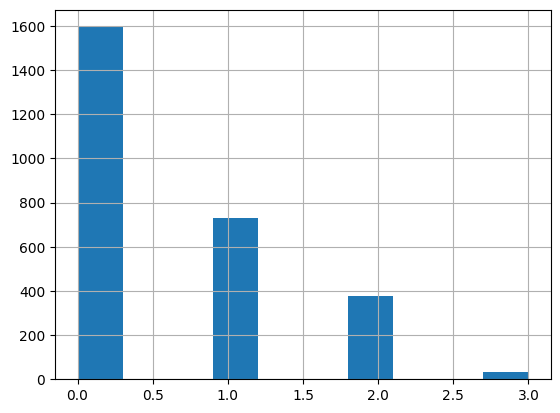

In [11]:
train["sii"].hist()

In [12]:
missing_percent_train = train.isnull().mean() * 100
missing_percent_train

Basic_Demos-Enroll_Season                  0.000000
Basic_Demos-Age                            0.000000
Basic_Demos-Sex                            0.000000
CGAS-Season                                0.000000
CGAS-CGAS_Score                            0.000000
Physical-Season                            0.000000
Physical-BMI                               0.000000
Physical-Height                            0.000000
Physical-Weight                            0.000000
Physical-Waist_Circumference              82.346491
Physical-Diastolic_BP                      0.000000
Physical-HeartRate                         0.000000
Physical-Systolic_BP                       0.000000
Fitness_Endurance-Season                   0.000000
Fitness_Endurance-Max_Stage               73.282164
Fitness_Endurance-Time_Mins               73.391813
Fitness_Endurance-Time_Sec                73.391813
FGC-Season                                 0.000000
FGC-FGC_CU                                 0.000000
FGC-FGC_CU_Z

In [13]:
# interation imputation

def create_interaction_features(df, feature_pairs):
    global cat_c
    for feature1, feature2 in feature_pairs:
        if(feature1 not in cat_c or feature2 not in cat_c):
            print("feature1:" + feature1 + ",feature2:" + feature2)
            new_feature_name = f"{feature1}_x_{feature2}"
            df[new_feature_name] = df[feature1] * df[feature2]
    return df

def create_chufa_features(df, feature_pairs):
    global cat_c
    for feature1, feature2 in feature_pairs:
        if feature1 not in cat_c or feature2 not in cat_c:
            print(f"feature1: {feature1}, feature2: {feature2}")
            
            # 构造 A/B 特征，先进行除法运算，但在除法之前控制出现0或NaN的情况
            new_feature_name1 = f"{feature1}_div_{feature2}"
            df[new_feature_name1] = df[feature1] / df[feature2]
            
            # 当A或B中有0或NaN时保留NaN
            df[new_feature_name1] = df[new_feature_name1].mask((df[feature1] == 0) | (df[feature2] == 0) | 
                                                               df[feature1].isna() | df[feature2].isna())
            
            # 构造 B/A 特征，类似方式处理
            new_feature_name2 = f"{feature2}_div_{feature1}"
            df[new_feature_name2] = df[feature2] / df[feature1]
            df[new_feature_name2] = df[new_feature_name2].mask((df[feature1] == 0) | (df[feature2] == 0) | 
                                                               df[feature1].isna() | df[feature2].isna())

    return df

In [14]:
feature_pairs = [
    ('PreInt_EduHx-computerinternet_hoursday', 'Basic_Demos-Age'),
    ('Basic_Demos-Age', 'SDS-SDS_Total_T'),
    ('FGC-FGC_SRR_Zone', 'SDS-SDS_Total_T'),
    ('BIA-BIA_BMC', 'Physical-HeartRate'),
    #('Fitness_Endurance-Season', 'Physical-Waist_Circumference'),
    ('BIA-BIA_Fat', 'Physical-BMI'),
    ('PreInt_EduHx-Season', 'Fitness_Endurance-Season'),
    ('SDS-SDS_Total_T', 'Physical-Systolic_BP'),
    ('Basic_Demos-Sex', 'FGC-FGC_PU_Zone')
]


train = create_interaction_features(train, feature_pairs)
test = create_interaction_features(test, feature_pairs)
train = create_chufa_features(train, feature_pairs)
test = create_chufa_features(test, feature_pairs)

feature1:PreInt_EduHx-computerinternet_hoursday,feature2:Basic_Demos-Age
feature1:Basic_Demos-Age,feature2:SDS-SDS_Total_T
feature1:FGC-FGC_SRR_Zone,feature2:SDS-SDS_Total_T
feature1:BIA-BIA_BMC,feature2:Physical-HeartRate
feature1:BIA-BIA_Fat,feature2:Physical-BMI
feature1:PreInt_EduHx-Season,feature2:Fitness_Endurance-Season
feature1:SDS-SDS_Total_T,feature2:Physical-Systolic_BP
feature1:Basic_Demos-Sex,feature2:FGC-FGC_PU_Zone
feature1:PreInt_EduHx-computerinternet_hoursday,feature2:Basic_Demos-Age
feature1:Basic_Demos-Age,feature2:SDS-SDS_Total_T
feature1:FGC-FGC_SRR_Zone,feature2:SDS-SDS_Total_T
feature1:BIA-BIA_BMC,feature2:Physical-HeartRate
feature1:BIA-BIA_Fat,feature2:Physical-BMI
feature1:PreInt_EduHx-Season,feature2:Fitness_Endurance-Season
feature1:SDS-SDS_Total_T,feature2:Physical-Systolic_BP
feature1:Basic_Demos-Sex,feature2:FGC-FGC_PU_Zone
feature1: PreInt_EduHx-computerinternet_hoursday, feature2: Basic_Demos-Age
feature1: Basic_Demos-Age, feature2: SDS-SDS_Total_T
fea

In [15]:
def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    
    X = train.drop(['sii'], axis=1)
    y = train['sii']
    test_data = test_data.drop(['sii'], axis=1)
    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead') # Nelder-Mead | # Powell
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': test_id,
        'sii': tpTuned
    })


    return submission, tKappa

In [16]:
best_params_lgbm = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,
    'lambda_l2': 0.01
}

In [17]:
from sklearn.preprocessing import LabelEncoder

# Function to preprocess data for LightGBM
def preprocess_data(df):
    # Identify non-numeric columns
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    
    # Apply label encoding to non-numeric columns
    label_encoders = {}
    for col in non_numeric_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    return df, label_encoders

# Apply preprocessing to both train and test data
train_preprocessed, train_encoders = preprocess_data(train)
test_preprocessed, _ = preprocess_data(test)


Light = lgb.LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
Submission_LGBM, k_lgbm = TrainML(Light, test_preprocessed)

Training Folds: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

Mean Train QWK --> 0.6558
Mean Validation QWK ---> 0.4048


----> || Optimized QWK SCORE ::  0.476


In [18]:
# Required imports
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # Required for HistGradientBoosting
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import VotingRegressor
from scipy.optimize import minimize

# Define the individual models
lgb_model = LGBMRegressor(**best_params_lgbm, random_state=SEED, verbose=-1)
xgb_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=SEED)
hgb_model = HistGradientBoostingRegressor(max_iter=200, max_depth=10, random_state=SEED)
cat_model = CatBoostRegressor(iterations=200, learning_rate=0.05, depth=6, verbose=0, random_state=SEED)

# Create a VotingRegressor
voting_regressor = VotingRegressor([
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('hgb', hgb_model),
    ('cat', cat_model)
])

# Prepare the data
X = train_preprocessed.drop(['sii'], axis=1)
y = train_preprocessed['sii']
test_data = test_preprocessed.drop(['sii'], axis=1)

# Train the VotingRegressor
voting_regressor.fit(X, y)

# Predict on train and test data
voting_oof_preds = voting_regressor.predict(X)
voting_test_preds = voting_regressor.predict(test_data)

# Optimize thresholds for the ensemble
def evaluate_predictions(thresholds, y_true, preds):
    rounded_preds = np.digitize(preds, bins=thresholds)
    return -cohen_kappa_score(y_true, rounded_preds, weights='quadratic')

opt_result = minimize(evaluate_predictions, x0=[0.5, 1.5, 2.5],
                      args=(y, voting_oof_preds),
                      method='Nelder-Mead')

assert opt_result.success, "Threshold optimization failed for ensemble."
optimized_thresholds = opt_result.x

# Apply optimized thresholds
voting_oof_rounded = np.digitize(voting_oof_preds, bins=optimized_thresholds)
voting_test_rounded = np.digitize(voting_test_preds, bins=optimized_thresholds)

# Evaluate optimized ensemble
optimized_ensemble_score = cohen_kappa_score(y, voting_oof_rounded, weights='quadratic')
print(f"Optimized Ensemble QWK Score (VotingRegressor): {optimized_ensemble_score:.4f}")


Optimized Ensemble QWK Score (VotingRegressor): 0.8941


In [19]:
Submission_ensemble, k_ensemble = TrainML(voting_regressor, test_preprocessed)

Training Folds: 100%|██████████| 5/5 [00:39<00:00,  7.81s/it]

Mean Train QWK --> 0.8586
Mean Validation QWK ---> 0.4202


----> || Optimized QWK SCORE ::  0.465


In [20]:
Submission_ensemble.to_csv('submission.csv', index=False)